In [18]:
# Check pytorch version
import torch

print(torch.__version__)

2.5.1


In [19]:
!nvidia-smi

Fri Dec  6 17:41:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.59                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P5             14W /  140W |    1941MiB /   8188MiB |     22%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [21]:
# Use GPU for training
device = torch.device("cuda")

In [22]:
_exp_name = 'mnist'

In [23]:
# Import necessary packages
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from omegaconf import OmegaConf
from tqdm.auto import tqdm

In [24]:
# Fix random seed for reproducibility
seed = 114514
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Avoid nondeterministic algorithms and disable benchmarks for convolution operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [25]:
from torchvision import datasets, transforms

# Pipeline for preprocessing of the image. 
transform = transforms.Compose([

    # Resize into a fixed size
    transforms.Resize((32, 32)),

    # Transform to pytorch tensorc
    transforms.ToTensor(),

    # Normalizes the pixel values to have a mean value of 0 and a standard deviation of 1, assuming initially in range (0, 1)
    transforms.Normalize((0.5,), (0.5,))
])

# Download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)


In [26]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

Train dataset has 60000 samples.
Test dataset has 10000 samples.
torch.Size([1, 32, 32])


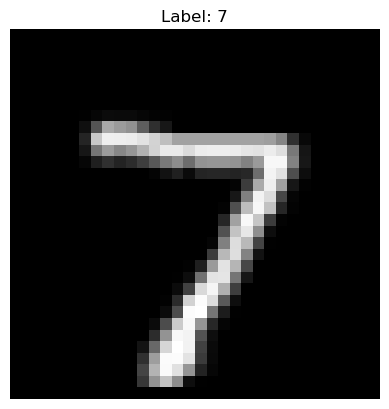

In [37]:
print(f'Train dataset has {len(train_dataset)} samples.')
print(f'Test dataset has {len(test_dataset)} samples.')

# Viualization of the first image
image_zero, target_zero = test_dataset[0]
print(np.shape(image_zero))
plt.imshow(image_zero.squeeze().numpy(), cmap="gray")
plt.title(f"Label: {target_zero}")
plt.axis("off")
plt.show()

In [ ]:
class Classfier(nn.Module):
    def __init__(self):
        # inherit attributes and methods of nn.Module
        super(Classfier, self).__init__()

        self.cnn = nn.Sequential(
            # Input size is [32, 32, 1]
            self.cnn_layer(in_channels=1, out_channels=64),     # [16, 16, 64]

            self.cnn_layer(in_channels=64, out_channels=128),       # [8, 8, 128]

            self.cnn_layer(in_channels=128, out_channels=256),      # [4, 4, 256]

            self.cnn_layer(in_channels=256, out_channels=512),       # [2, 2, 512]

            # self.cnn_layer(in_channels=512, out_channels=512)        # [1, 1, 512]
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def cnn_layer(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                  pooling_kernel_size=2, pooling_stride=2, pooling_padding=0):
        """
        Create a default CNN layer. In and out channels are required parameters
        Parameters:
        - in_channels: Number of input channels.
        - out_channels: Number of output filter channels.
        - kernel_size: Size of the convolutional kernel.
        - stride: Stride of the convolution.
        - padding: Padding value added to the input.
        - pooling_kernel_size: Size of the maxpooling kernel.
        - pooling_stride: Stride of the maxpooling.
        - pooing_padding: Padding value added to the convolution output channel.

        Returns:
        - nn.Sequential: A block with convolution layer and pooling layer.
        """

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            # nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(pooling_kernel_size, pooling_stride, pooling_padding)
        )
    
    def forward(self, x):

        filter = self.cnn(x)
        filter = filter.view(filter.size()[0], -1)

        return self.fc(filter)

In [29]:
config = OmegaConf.load('config.yaml')
config_dict = OmegaConf.to_container(config, resolve=True)

In [30]:
# Divide MNIST dataset into training, vaildation and test sets

# 48,000 figures as training data, 12,000 figures as validation data
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, valid = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train, batch_size=config_dict['batch_size'], shuffle=True)
valid_loader = DataLoader(valid, batch_size=config_dict['batch_size'], shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=config_dict['batch_size'], shuffle=False, pin_memory=True)

In [31]:
# Initiallize the model to device
model = Classfier().to(device)

# Set up loss function and optimizer
criterion = getattr(nn, config_dict['criterion'])()

optimizer = torch.optim.Adam(model.parameters(), lr = config_dict['lr'])

patience = config_dict['patience']

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=config_dict['gamma'])

In [32]:
"""
Start training
"""
n_epoches = config_dict['n_epoches']
stale = 0
best_acc = 0

for epoch in range(n_epoches):

    """ -----  Training  ----- """

    # Turn to train mode
    model.train()

    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # Load data and label to device
        data, label = batch
        data, label = data.to(device), label.to(device)

        # Clear gradient buffers
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)

        # Compute loss
        loss = criterion(output, label)

        # Backward propagation
        loss.backward()

        # Clip the gradient norms for stable training
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters
        optimizer.step()

        # Compute the accuracy for current batch
        acc = (output.argmax(dim=-1) == label).float().mean()

        # Record the loss and accuracy
        train_loss.append(loss.item())
        train_accs.append(acc)
    
    scheduler.step()
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epoches:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")


    """ -----  Validation  ----- """
    # Turn to validation mode
    model.eval()

    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):

        data, label = batch
        data, label = data.to(device), label.to(device)

        # No need for gradient computation, so acclerate by no_grad
        with torch.no_grad():
            
            output = model(data)

        loss = criterion(output, label)
        acc = (output.argmax(dim=-1) == label).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epoches:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # # update logs
    # if valid_acc > best_acc:
    #     with open(f"./{_exp_name}_log.txt","a"):
    #         print(f"[ Valid | {epoch + 1:03d}/{n_epoches:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    # else:
    #     with open(f"./{_exp_name}_log.txt","a"):
    #         print(f"[ Valid | {epoch + 1:03d}/{n_epoches:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # save model of best accurancy
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break


  0%|          | 0/750 [00:00<?, ?it/s]

[ Train | 001/002 ] loss = 0.30827, acc = 0.89477


  0%|          | 0/188 [00:00<?, ?it/s]

[ Valid | 001/002 ] loss = 0.06602, acc = 0.98213
Best model found at epoch 0, saving model


  0%|          | 0/750 [00:00<?, ?it/s]

[ Train | 002/002 ] loss = 0.07173, acc = 0.98046


  0%|          | 0/188 [00:00<?, ?it/s]

[ Valid | 002/002 ] loss = 0.05198, acc = 0.98795
Best model found at epoch 1, saving model


In [35]:
model_best = Classfier().to(device)
# Load the model of the best performance
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
test_acc = []

with torch.no_grad():
    
    for batch in tqdm(test_loader):

        data, label = batch
        data, label = data.to(device), label.to(device)

        pred = model_best(data.to(device))
        
        acc = (pred.argmax(dim=-1) == label).cpu().float().mean()
        test_acc.append(acc)

test_acc = sum(test_acc) / len(test_acc)

/tmp/ipykernel_317/1718212793.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))


  0%|          | 0/157 [00:00<?, ?it/s]

In [36]:
print(f'Final test accurancy is: {test_acc:.5f}')

Final test accurancy is: 0.98905
